# Stellar Luminosity Modeling
## Part II — Polynomial Features and Interaction Terms

**Objective:**  
Model stellar luminosity (L) using two features (mass M and temperature T) and
engineered polynomial/interaction terms. The model is trained using gradient
descent implemented from first principles.

$$
\hat{L} = Xw + b
$$

where the design matrix uses:
$$
X = [M,\ T,\ M^2,\ M\cdot T]
$$


In [35]:

import numpy as np
import matplotlib.pyplot as plt



In [36]:
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])


In [37]:
T_scaled = T / 1000.0


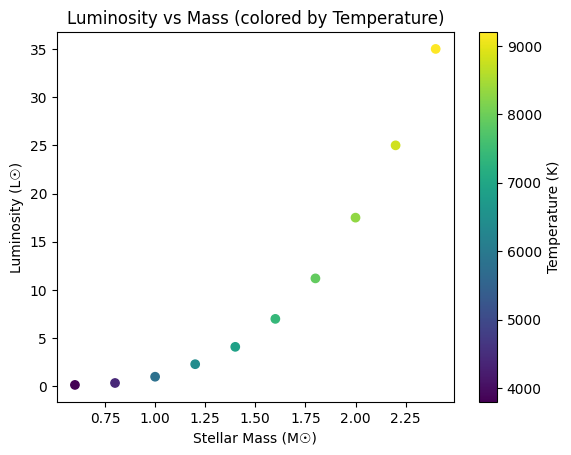

In [38]:
plt.figure()
sc = plt.scatter(M, L, c=T)
plt.xlabel("Stellar Mass (M☉)")
plt.ylabel("Luminosity (L☉)")
plt.title("Luminosity vs Mass (colored by Temperature)")
plt.colorbar(sc, label="Temperature (K)")
plt.show()


### Dataset Visualization

Luminosity increases with mass, but temperature also changes across the samples.
Using color helps show that stars with different temperatures can have different
luminosities even when mass is similar. This motivates using both M and T in the
model, along with extra terms to capture curved behavior.


In [39]:
def build_design_matrix(M, T, model="M3"):
    M = M.reshape(-1, 1)
    T = T.reshape(-1, 1)
    
    if model == "M1":
        X = np.hstack([M, T])
    elif model == "M2":
        X = np.hstack([M, T, M**2])
    elif model == "M3":
        X = np.hstack([M, T, M**2, M*T])
    else:
        raise ValueError("model must be 'M1', 'M2', or 'M3'")
        
    return X


In [40]:
X3 = build_design_matrix(M, T_scaled, model="M3")
X3.shape


(10, 4)

In [41]:
def predict_X(X, w, b):
    return X @ w + b



In [42]:
def mse_cost_X(X, L, w, b):
    L_hat = predict_X(X, w, b)
    return np.mean((L_hat - L)**2)



In [43]:
def gradients_X(X, L, w, b):
    N = X.shape[0]
    L_hat = predict_X(X, w, b)
    error = L_hat - L
    
    dw = (2 / N) * (X.T @ error)
    db = (2 / N) * np.sum(error)
    
    return dw, db



In [44]:
def gradient_descent_X(X, L, alpha=0.01, iterations=5000):
    w = np.zeros(X.shape[1])
    b = 0.0
    loss_history = []

    for _ in range(iterations):
        dw, db = gradients_X(X, L, w, b)
        w -= alpha * dw
        b -= alpha * db
        loss_history.append(mse_cost_X(X, L, w, b))

    return w, b, loss_history



In [45]:
w3, b3, loss3 = gradient_descent_X(X3, L, alpha=0.001, iterations=5000)
w3, b3, loss3[-1]



(array([-0.21747792, -2.31690507,  3.27936608,  1.46429428]),
 1.4496392980664028,
 5.505565397443876)

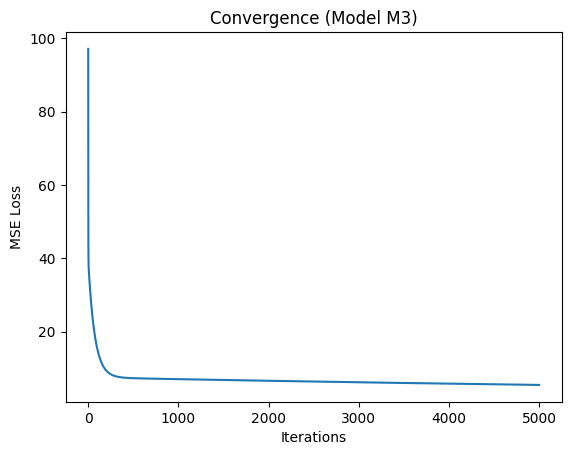

In [46]:
plt.figure()
plt.plot(loss3)
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Convergence (Model M3)")
plt.show()



In [47]:
models = ["M1", "M2", "M3"]
all_results = {}

for model in models:
    X = build_design_matrix(M, T_scaled, model=model)
    w, b, loss = gradient_descent_X(X, L, alpha=0.001, iterations=5000)
    L_hat = predict_X(X, w, b)

    all_results[model] = {
        "w": w,
        "b": b,
        "final_loss": loss[-1],
        "pred": L_hat
    }

    print(f"{model} -> final_loss={loss[-1]:.4f}, b={b:.4f}, w={w}")


M1 -> final_loss=28.1330, b=-9.8241, w=[12.47370757  0.29032783]
M2 -> final_loss=4.1176, b=0.2658, w=[ 0.75498504 -1.5904055   7.65310701]
M3 -> final_loss=5.5056, b=1.4496, w=[-0.21747792 -2.31690507  3.27936608  1.46429428]


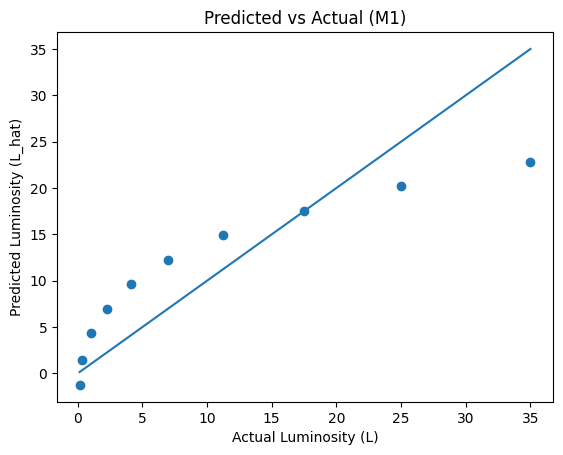

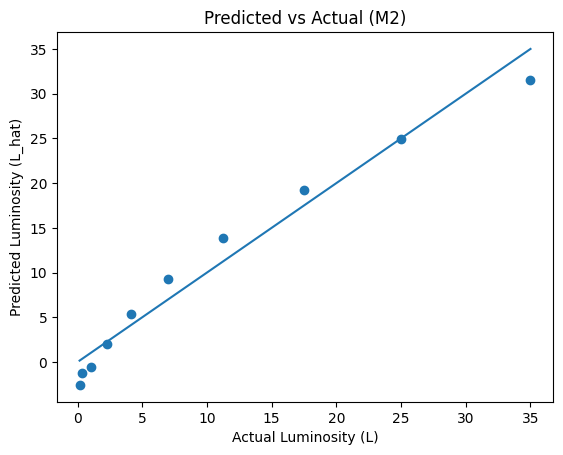

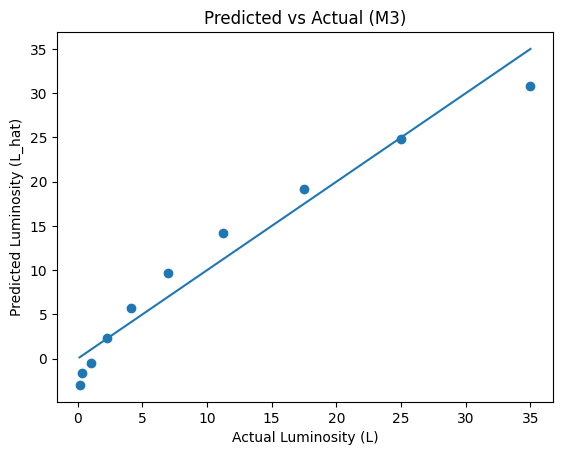

In [48]:
for model in models:
    plt.figure()
    plt.scatter(L, all_results[model]["pred"])
    plt.plot([L.min(), L.max()], [L.min(), L.max()])  # línea ideal y=x
    plt.xlabel("Actual Luminosity (L)")
    plt.ylabel("Predicted Luminosity (L_hat)")
    plt.title(f"Predicted vs Actual ({model})")
    plt.show()


### Feature Selection Experiment (M1 vs M2 vs M3)

M1 uses only mass and temperature, so it is the simplest option.
M2 adds the term $M^2$, which helps capture curvature.
M3 adds the interaction $M\cdot T$, which can improve the fit if temperature and
mass combine to explain luminosity.

Overall, the model with more informative terms should reduce the final loss and
produce predictions closer to the ideal diagonal in the plots.


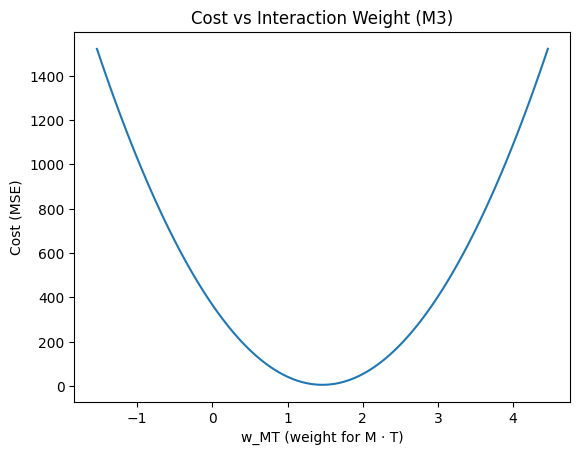

(1.464294281104769, 5.609842055080286)

In [49]:

X3 = build_design_matrix(M, T_scaled, model="M3")
w3, b3, loss3 = gradient_descent_X(X3, L, alpha=0.001, iterations=5000)


w_mt_center = w3[3]
w_mt_range = np.linspace(w_mt_center - 3, w_mt_center + 3, 120)

costs = []
for w_mt in w_mt_range:
    w_temp = w3.copy()
    w_temp[3] = w_mt
    costs.append(mse_cost_X(X3, L, w_temp, b3))

plt.figure()
plt.plot(w_mt_range, costs)
plt.xlabel("w_MT (weight for M · T)")
plt.ylabel("Cost (MSE)")
plt.title("Cost vs Interaction Weight (M3)")
plt.show()

w_mt_center, min(costs)


### Cost vs Interaction Term

In this experiment, only the coefficient of the interaction feature $(M\cdot T)$
was changed while keeping the other parameters fixed. The curve shows how much
the model depends on that interaction.

If the cost rises when moving away from the best value, it means the interaction
term is helping the model fit the data and is not just noise.


In [50]:
M_new = np.array([1.3])
T_new = np.array([6600]) / 1000.0  # scaled

X_new = build_design_matrix(M_new, T_new, model="M3")
L_new_pred = predict_X(X_new, w3, b3)

L_new_pred


array([3.98111816])